# ER190C Final Project: SF Eviction Prediction Model
Fall, 2018

Amelia Baum

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import keras

## Abstract (5 points)
Rising rents and neighborhood change in San Francisco over the last 10 years have decreased the affordability of the rental housing market for working and middle class households in the city. Research suggests that these changes have led to widespread displacement from San Francisco, a portion of which can be modeled with eviction statistics. Others have employed the use of machine learning techniques to predict gentrification and neighborhood change, and a more limited set of studies have attempted to predict evictions. I used time lagged data on demographics, the built environment and transportation access to predict eviction rates by census tracts in San Francisco using Ridge, Random Forest and K-Nearest Neighbors regression. Ridge and KNN generalized well with high predictive accuracy, and provides an effective starting point for more robust and explainable predictive models to be used by policymakers and housing advocates. 



## Project Background (5 points)
Eviction can have devastating effects on individual households, increasing susceptibility to homelessness, reducing access to credit, disrupting children's academic performance <cite data-cite="6336556/4QEZN9SC"></cite> and  increasing stress and depression <cite data-cite="6336556/UQL6UVGE"></cite>. Widespread evictions, especially those associated with Ellis act invocations and condo conversions, can destabilize communities, reduce social networks and decrease social capital of marginalized residents. Eviction is a widespread problem across lower income communities across racial groups, but research suggests that Black and Hispanic renters are particularly vulnerable, at least in some markets. <cite data-cite="6336556/JI2BU5J8"></cite> As major cities nationwide become increasingly unaffordable and socioeconomically homogenous, a significant amount of research has employed the use of statistical methods, including predictive models, to investigate trends such as gentrification <cite data-cite="6336556/A69SNZW5"></cite>, residential mobility <cite data-cite="6336556/5J52DF82"></cite>, eviction <cite data-cite="6336556/7FPVL4DT"></cite>, crime, wealth, and even changes in the built environment <cite data-cite="6336556/XNKWE6KL"></cite>. Predicting indicators of neighborhood change such as evictions can be helpful, serving as early warning signs that can encourage proactive policies, such as increased affordable housing accomodation, provide evidence for controversial policies such as rent stabilization measures, or indicate a need to allocate resources to particular public agencies or funds. A study by Matthew Desmond and Carl Gershenson tested a host of individual and neighborhood level characteristics (at the block group level) in their analysis of eviction trends in Milwaukee, using a discrete hazard model to assess how these characteristics influenced the whether households were evicted, and when. <cite data-cite="undefined"></cite> A project by Kenny Durrell available on github used a random forest regressor and a top-down hierarchical ARIMAX model to predict evictions by zip code in San Francisco, using Open SF’s eviction notice dataset, which includes eviction data from 1997-2018 by address. <cite data-cite="6336556/H77PJNWG"></cite> This project takes an innovative approach to the eviction prediction problem by using some time lagged features. Though the project report does not mention the justification, the use of time lagged features is appropriate for predicting evictions since it is consistent with literature about neighborhood change, which suggests that there is the substantial delay between demographic and economic shifts and resulting neighborhood change (ie: eviction rates). This project served as the primary inspiration for my model, but I employed the use of two additional algorithms (Ridge and KNN) and used LASSO to the select the most relevant from a broader set of features, including transportation features and relationships with neighboring geographies that Durrell’s project did not address. Most significantly, I felt that the zip code was too coarse of a scale to draw meaningful conclusions about neighborhood-level evictions rates (for instance, the majority of the Mission district in SF is one zip code), so I used census tract level features to predict the eviction rate instead. 


## Project Question (5 points)

1. What will be the eviction rate in each census tract in San Francisco in 2019?
2. How well can we predict the eviction rate of a census tract in San Francisco using a defined set of demographic, transportation and built environment related variables?

Both of these questions articulate the need to quantify the extent and dispersion of evictions in San Francisco. Determining where evictions are happening, and how many are happening can serve as early warning signs of neighborhood change and economic patterns. The information is also potentially helpful to social service organizations and arms of local government that may have resources available to help households and communities affected by the eviction crisis.   Perhaps most directly, quantifying and predicting evictions provides data that can help backup discussions about gentrification, homelessness and unfair real estate practices in city council meetings, the Planning department and the mayor’s office, where marginalized groups most affected by eviction are usually the least represented.
 

## Input Data Description (5 points)


**Eviction Data** <br>
**Source:** SFGov, “Eviction notices filed with the San Francisco Rent Board per San Francisco Administrative Code 37.9(c).” <br>
**Structure:** .csv<br>
**Granularity:** One eviction record per line, with time/date/location (lat/lon, zip code, address) information. One column for each type of eviction with a boolean variable indicating which type the eviction is.<br>
**Scope:** Unclear what fraction of actual evictions are present in the dataset, though legally all area supposed to be. --% of the data contains NaN elements in critical fields.<br>
**Temporality:** data is from 1997-2018<br>
**Faithfulness:** administrative dataset maintained by the city, no reason to believe there are any issues of misrepresentation, though eviction rates did seem artificially low to an untrained observer. <br><br>



In [45]:
evictions = pd.read_csv('data/Eviction_Notices.csv')
evictions.head()

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M172475,3400 Block Of Cabrillo Street,San Francisco,CA,94121,10/06/2017,False,True,False,False,...,False,False,False,False,False,False,NaN,1.0,Outer Richmond,"(37.77386737514161, -122.49557322465877)"
1,M172687,200 Block Of Lincoln Way,San Francisco,CA,94122,10/23/2017,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.766087774671476, -122.46055272384265)"
2,M172665,100 Block Of San Jose Avenue,San Francisco,CA,94110,10/27/2017,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Mission,"(37.75244836363184, -122.42150560125395)"
3,M172474,1500 Block Of Gough Street,San Francisco,CA,94109,10/06/2017,False,True,False,False,...,False,False,False,False,False,False,NaN,2.0,Western Addition,"(37.78784203836025, -122.4251203921454)"
4,M172571,900 Block Of Larkin Street,San Francisco,CA,94109,10/16/2017,False,False,False,True,...,False,False,False,False,False,False,NaN,6.0,Tenderloin,"(37.7863419197514, -122.41806508253852)"


**ACS Data** <br>
**Source:** American Community Survey, U.S. Census<br>
**Structure:** .csv<br>
**Granularity:** One census tract per line, separate file for each year. Margins of error included in dataset but not included in model. <br>
**Scope:**<br>
**Temporality:** Used ACS 5 YR estimates from: 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017 (to predict).<br>
**Faithfulness:** The American Community Survey is administered every year to a sample of the U.S. population. The 5YR estimates are compiled rolling averages from the 5 years preceding and including the published date (ie: 2015 estimates are rolling averages from 2011-2015). The ACS data has relatively high margins of error for some variables and suffers from similar non-response bias as the U.S. Census. Regardless, it is considered the most accurate available source on demographics by researchers and policymakers.<br><br>

In [46]:
#race data
race09 = pd.read_csv('data/B02001_race/ACS_09_5YR_B02001_race_clean.csv')
race09.head()

,Id2,Geography,Estimate; Total:,Estimate; Total: - White alone,Estimate; Total: - Black or African American alone,Estimate; Total: - American Indian and Alaska Native alone,Estimate; Total: - Asian alone,Estimate; Total: - Native Hawaiian and Other Pacific Islander alone
0,6075010100,"Census Tract 101, San Francisco County, Califo...",3685,2013,605,0,967,20
1,6075010200,"Census Tract 102, San Francisco County, Califo...",4354,3555,45,0,387,0
2,6075010300,"Census Tract 103, San Francisco County, Califo...",3736,2342,85,9,1184,9
3,6075010400,"Census Tract 104, San Francisco County, Califo...",4481,3152,0,0,1203,0
4,6075010500,"Census Tract 105, San Francisco County, Califo...",2415,1879,11,0,381,0


In [47]:
#housing units
units = pd.read_csv('data/B25001_units/ACS_09_5YR_B25001_units_clean.csv')
units.head()

,Id2,Geography,Estimate; Total
0,6075010100,"Census Tract 101, San Francisco County, Califo...",2036
1,6075010200,"Census Tract 102, San Francisco County, Califo...",3031
2,6075010300,"Census Tract 103, San Francisco County, Califo...",2262
3,6075010400,"Census Tract 104, San Francisco County, Califo...",2995
4,6075010500,"Census Tract 105, San Francisco County, Califo...",1805


In [48]:
#median year built
yearb = pd.read_csv('data/B25035_yearbuilt/ACS_09_5YR_B25035_built_clean.csv')
yearb.head()

,Id2,Geography,Estimate; Median year structure built
0,6075010100,"Census Tract 101, San Francisco County, Califo...",1972
1,6075010200,"Census Tract 102, San Francisco County, Califo...",1939-
2,6075010300,"Census Tract 103, San Francisco County, Califo...",1939-
3,6075010400,"Census Tract 104, San Francisco County, Califo...",1939-
4,6075010500,"Census Tract 105, San Francisco County, Califo...",1973


In [49]:
moved = pd.read_csv('data/B25039_moved/ACS_09_5YR_B25039_moved_clean.csv')
moved.head()

,Id2,Geography,Estimate; Median year householder moved into unit -- - Renter occupied
0,6075010100,"Census Tract 101, San Francisco County, Califo...",2004
1,6075010200,"Census Tract 102, San Francisco County, Califo...",2003
2,6075010300,"Census Tract 103, San Francisco County, Califo...",2003
3,6075010400,"Census Tract 104, San Francisco County, Califo...",2003
4,6075010500,"Census Tract 105, San Francisco County, Califo...",2004


In [50]:
burden = pd.read_csv('data/B25071_burden/ACS_09_5YR_B25071_burden_clean.csv')
burden.head()

,Id2,Geography,Estimate; Median gross rent as a percentage of household income
0,6075010100,"Census Tract 101, San Francisco County, Califo...",28.7
1,6075010200,"Census Tract 102, San Francisco County, Califo...",23.8
2,6075010300,"Census Tract 103, San Francisco County, Califo...",22.2
3,6075010400,"Census Tract 104, San Francisco County, Califo...",22.3
4,6075010500,"Census Tract 105, San Francisco County, Califo...",24.7


In [51]:
size = pd.read_csv('data/S1101_size/ACS_09_5YR_S1101_size_clean.csv')
size.head()

,Id2,Geography,Total; Estimate; Average household size
0,6075010100,"Census Tract 101, San Francisco County, Califo...",1.92
1,6075010200,"Census Tract 102, San Francisco County, Califo...",1.57
2,6075010300,"Census Tract 103, San Francisco County, Califo...",1.99
3,6075010400,"Census Tract 104, San Francisco County, Califo...",1.80
4,6075010500,"Census Tract 105, San Francisco County, Califo...",1.62


In [52]:
edu = pd.read_csv('data/S1501_edu/ACS_09_5YR_S1501_edu_clean.csv')
edu.head()

,Id2,Geography,Total; Estimate; Bachelor's degree
0,6075010100,"Census Tract 101, San Francisco County, Califo...",39.7
1,6075010200,"Census Tract 102, San Francisco County, Califo...",41.5
2,6075010300,"Census Tract 103, San Francisco County, Califo...",37.0
3,6075010400,"Census Tract 104, San Francisco County, Califo...",44.4
4,6075010500,"Census Tract 105, San Francisco County, Califo...",36.5


**Muni bus stop data**<br>
**Source:** DataSF “SFMTA Transit Stop and Schedule Data”<br>
**Structure:** .txt<br>
**Granularity:** One Muni stop per line, including stop id, string name of location and lat/lon of location (used to geocode and aggregate by census tract).<br>
**Scope:** The dataset represents the full scope of Muni bus stops within the city of San Francisco.<br>
**Temporality:** not time specific<br>
**Faithfulness:** From official SFMTA administrative dataset, no reason to doubt faithfulness.<br><br>


In [53]:
stops = pd.read_csv('data/geocoded_muni_stops.csv')
stops.head()

,Unnamed: 0,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url
0,0,390,1390,19th Avenue & Holloway St,,37.721190,-122.475096,,
1,1,913,1913,DUBLIN ST & LAGRANDE AVE,,37.719192,-122.425802,,
2,2,3003,13003,2nd St & Brannan St,,37.781827,-122.391945,,
3,3,3004,13004,2nd St & Brannan St,,37.781854,-122.392232,,
4,4,3009,13009,2nd St & Harrison St,,37.784532,-122.395325,,


**Commuter Shuttle Data**<br>
**Source:** Data.gov “Commuter Shuttle Stops”<br>
**Structure:** .shp<br>
**Granularity:** One commuter shuttle stop per line, including the from and to street of the route, string name of location and lat/lon of location (used to geocode and aggregate by census tract).<br>
**Scope:** The dataset represents the full scope of commuter shuttle stops registered with the commuter shuttle program within the city of San Francisco.<br>
**Temporality:** not time specific<br>
**Faithfulness:** From official SFMTA administrative dataset, no reason to doubt faithfulness.

In [54]:
shuttles = pd.read_csv('data/shuttles_geocodedbytract.csv')
shuttles.head()

,Unnamed: 0,Geoid,from_st,to_st,geometry,Latitude,Longitude
0,0,6075020300,16TH ST,17TH ST,POINT (-122.431645756432 37.763622580921),37.763623,-122.431646
1,1,6075023103,HUDSON AVE,CASHMERE ST END,POINT (-122.382957235907 37.735744935444),37.735745,-122.382957
2,2,6075023103,HUDSON AVE,HARBOR RD,POINT (-122.381188030573 37.733369713131),37.733370,-122.381188
3,3,6075023103,HUDSON AVE,REUEL CT END,POINT (-122.383074321058 37.736501775361),37.736502,-122.383074
4,4,6075025401,PARK ST,HIGHLAND AVE,POINT (-122.418862411824 37.737045357212),37.737045,-122.418862


## Data Cleaning (10 points)
In this section you will walk through the data cleaning and merging process.  Explain how you make decisions to clean and merge the data.  Explain how you convince yourself that the data don't contain problems that will limit your ability to produce a meaningful analysis from them.  

[Chapter 4](https://www.textbook.ds100.org/ch/04/cleaning_intro.html) of the DS100 textbook might be helpful to you in this section.  

There was a very substantial cleaning process involved in creating these models. Specifically, I needed to geocode the evictions dataset and aggregate them by census tract. I used a python wrapper (censusgeocode) for the Federal Communication Commission's Census API, which returned a FIPS id for each lat/lon coordinate. This process was time consuming since the API took ~1.2 seconds per eviction record. 

I also needed to clean the demographic and built environment data from the census to get it into a format that I could use in the models. This was laborious because the census is very inconsistent in their dataformatting, and there were a variety of issues with datatypes that I had to deal with one by one. More details in the "demog 2" notebook

The Muni and commutter shuttle datasets were the easiest to work with by far, requiring only a simple merge and some of the aforementioned geocoding. More details in the "190 Project Transit data cleaning" notebook

To assess the geographic neighbors of the census tract for one of my variables, I write a script using geopandas, another python library to find geographic neighbors from a shapefile of census tracts that I prepared. More details in the "Evictions Neighbors" notebook

## Data Summary and Exploratory Data Analysis (10 points)

In this section you should provide a tour through some of the basic trends and patterns in your data.  This includes providing initial plots to summarize the data, such as box plots, histograms, trends over time, scatter plots relating one variable or another.  

[Chapter 6](https://www.textbook.ds100.org/ch/06/viz_intro.html) of the DS100 textbook might be helpful for providing ideas for visualizations that describe your data.  

### Exploratory Feature Scatterplots

These plots help show underlying relationships between chosen features and the target variable (number of evictions per housing unit) in each census tract.

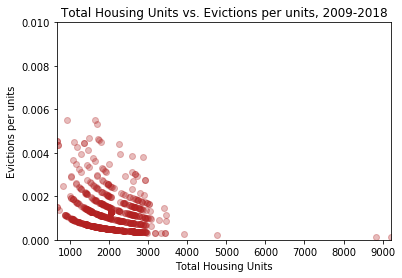

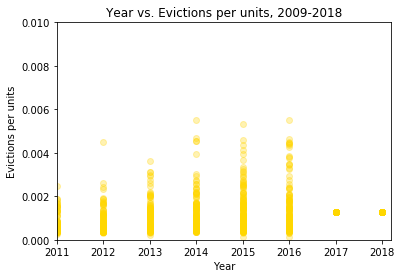

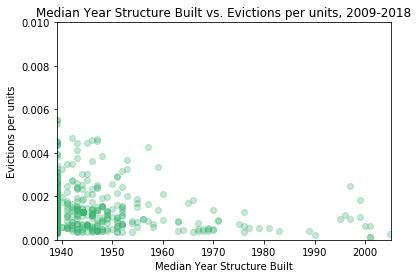

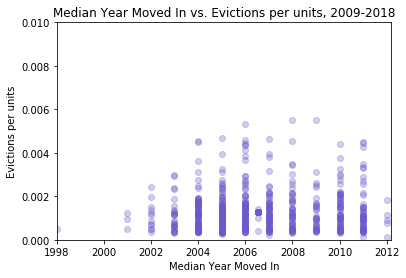

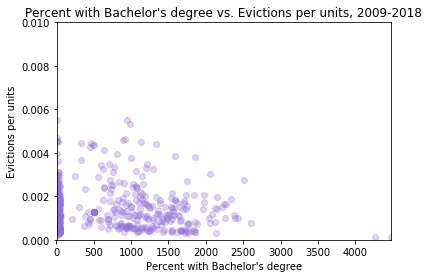

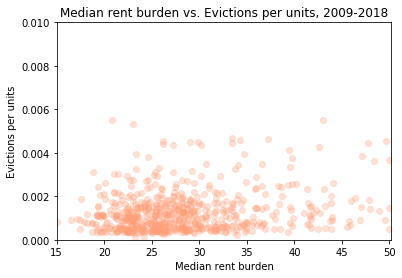

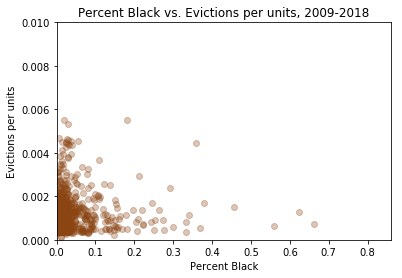

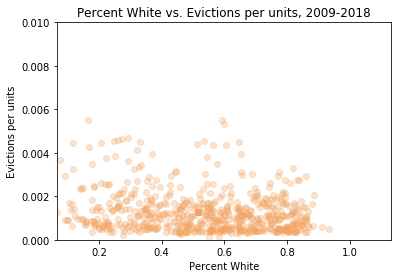

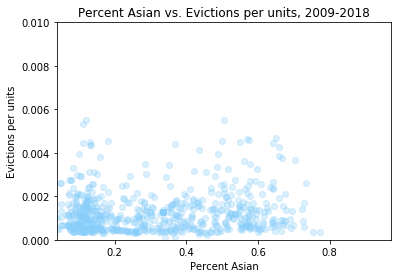

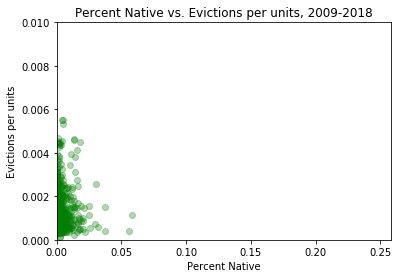

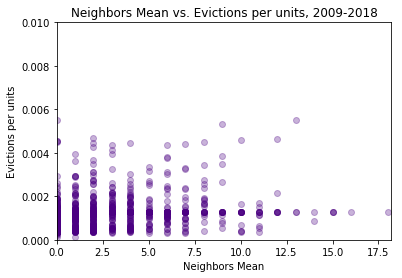

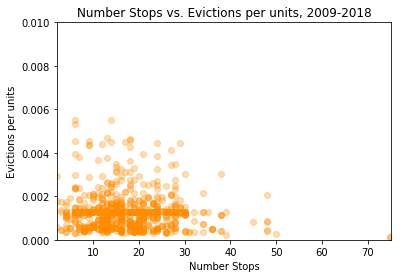

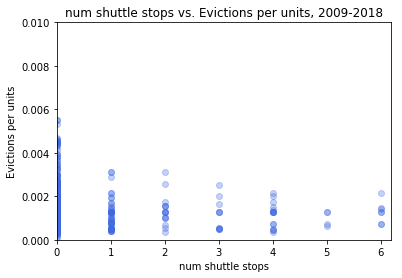

In [55]:
features = pd.read_csv('data/exploratory_data.csv')

colors = ['firebrick', 'gold', 'mediumseagreen', 'slateblue', 'mediumpurple', 'lightsalmon', 'saddlebrown',
         'sandybrown', 'lightskyblue', 'g', 'indigo', 'darkorange', 'royalblue']

for col, color in zip(features.columns[features.columns != 'Evictions per units'], colors):
    plt.scatter(features[col], features["Evictions per units"], c=color, alpha=.3)
    plt.title(col + " vs. Evictions per units, 2009-2018")
    plt.ylim((0, 0.01))
    plt.xlim((min(features[col]), max(features[col])+0.2))
    plt.ylabel("Evictions per units")
    plt.xlabel(col)
    plt.show()


### Feature Correlations

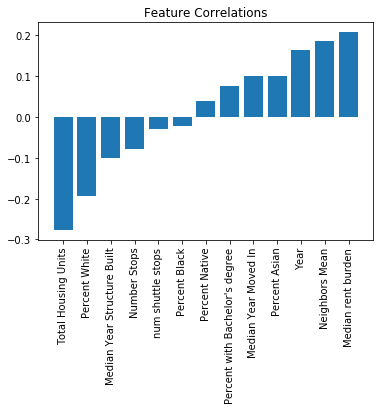

In [56]:
values = features.corr()["Evictions per units"].values
indices = features.corr()["Evictions per units"].index

sorted_one = sorted(zip(indices, values), key=lambda x: x[1])[:-1]
plt.bar([x[0] for x in sorted_one], [x[1] for x in sorted_one])
plt.title("Feature Correlations")
plt.xticks([x[0] for x in sorted_one], rotation='vertical', fontsize=10);
plt.show()

As the chart shows, none of the features are particularly highly correlated with the reponse, but some are more than others. The LASSO regression below helped me make the decision about which ones to include based on their correlation to the response.

### Load in Data and split into training, test sets

In [57]:
from sklearn.model_selection import train_test_split
features_df = pd.read_csv("data/features_with_shuttles.csv")
features = ['Total Housing Units','Percent Asian', 'Percent White', 'Percent Black','Median Year Structure Built',
           'Number Stops','Year', 'Percent Native', 'Median Year Moved In', 'Median rent burden', "Percent with Bachelor's degree",
           'Neighbors Mean', "Evictions per units", "geometry"]

features_df_keep = features_df.loc[:, features_df.columns.isin(features)]
#features_df_keep.to_csv('data/exploratory_data.csv', index=False)

X = features_df_keep.loc[:, features_df_keep.columns != 'Evictions per units']
y = features_df_keep.loc[:,'Evictions per units']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [58]:
def normalize_columns(data, mean_df, std_df):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    normalized_data=(data-mean_df.mean())/std_df.std()

    return normalized_data

In [59]:
def unnormalize_columns(data, mean_df, std_df):
    unnormalized_data=(data*std_df.std())+mean_df.mean()

    return unnormalized_data

In [60]:
normal_Xtrain = normalize_columns(X_train, X_train, X_train)
normal_Ytrain = normalize_columns(y_train, y_train, y_train)

### Feature Importance with LASSO
I chose features based on data availability, the time available to access and processs them, and my own existing understanding of factors related to eviction. Before fitting any of my models, I used LASSO to find out which of the 13 features I originally started with would be most useful for predicting number of evictions per housing unit in each census tract.


In [61]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from collections import OrderedDict

cv_alphas = np.linspace(1e-10, 1, 10000)

lasso = LassoCV(alphas=cv_alphas, normalize=False, max_iter=1e6).fit(normal_Xtrain, normal_Ytrain)
lcv_alpha_normal = lasso.alpha_
print("optimal alpha:", lcv_alpha_normal)

lasso_fit = Lasso(alpha=lcv_alpha_normal).fit(normal_Xtrain, normal_Ytrain)
lcoefficients = lasso_fit.coef_

lasso_coef_dict = OrderedDict()
for coef, feature in zip(lasso_fit.coef_, normal_Xtrain.columns):
    lasso_coef_dict[feature] = coef
sorted_coefs_lasso = OrderedDict(sorted(lasso_coef_dict.items(), key=lambda t: t[1]))
print("LASSO coefficients", sorted_coefs_lasso)


/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


optimal alpha: 0.000100010100990099
LASSO coefficients OrderedDict([('Percent White', -0.8273534447429608), ('Percent Asian', -0.7450957075588495), ('Percent Black', -0.3456975551379692), ('Total Housing Units', -0.23966568956178969), ('Median Year Structure Built', -0.05956779830256943), ('geometry', -0.05752661530087342), ('Year', -0.03329586422826841), ('Number Stops', -0.011690470858501644), ('Median Year Moved In', 0.004635167530103695), ('Percent Native', 0.01696024693341618), ('Median rent burden', 0.11292807096625207), ("Percent with Bachelor's degree", 0.15039521890706603), ('Neighbors Mean', 0.17470443247458625)])


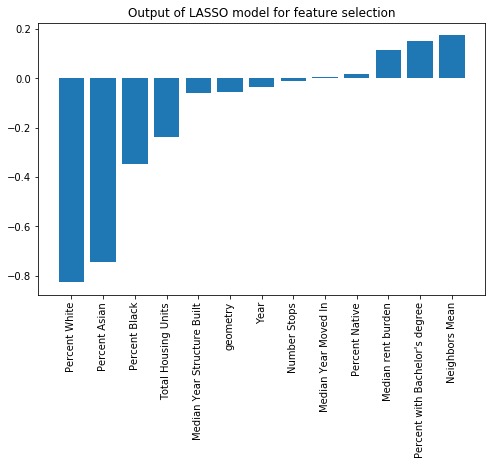

In [62]:
plt.figure(figsize=(8,5))
plt.bar(sorted_coefs_lasso.keys(), sorted_coefs_lasso.values())
plt.title("Output of LASSO model for feature selection")
plt.xticks(list(sorted_coefs_lasso.keys()), rotation='vertical', fontsize=10)
plt.show()

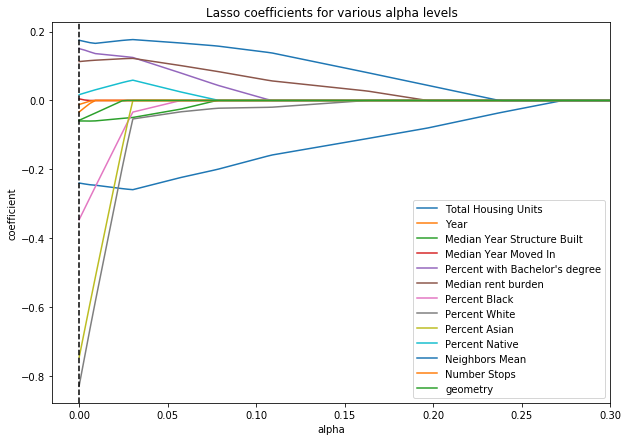

In [63]:
from sklearn.linear_model import Lasso
num_features = 13
lasso_coeffs = [[] for _ in range(num_features)]
alphas = np.linspace(0.0001, 0.3, 100)
for alpha in alphas:
    lasso_fit = Lasso(alpha=alpha).fit(normal_Xtrain, normal_Ytrain)
    for i, c in enumerate(lasso_fit.coef_):
        lasso_coeffs[i].append(c)
        
fig= plt.figure(figsize=(10,7))
for i, coeffs in enumerate(lasso_coeffs):
    plt.plot(alphas, coeffs, label=X_train.columns[i]);
plt.axvline(lcv_alpha_normal, c='black', ls='dashed')
plt.title("Lasso coefficients for various alpha levels")
plt.xlabel("alpha")
plt.xlim(-0.015, 0.3)
plt.ylabel("coefficient")
plt.legend();


The chart above shows the LASSO regression with various different alpha values. The black dotted line shows the optimal alpha level used by the LASSO model, as determined by LassoCV.

## Forecasting and Prediction Modeling (25 points)

This section is where the rubber meets the road.  In it you must:
1. Explore at least 3 prediction modeling approaches, ranging from the simple (e.g. linear regression, KNN) to the complex (e.g. SVM, random forests, Lasso).  
2. Motivate all your modeling decisions.  This includes parameter choices (e.g., how many folds in k-fold cross validation, what time window you use for averaging your data) as well as model form (e.g., If you use regression trees, why?  If you include nonlinear features in a regression model, why?). 
1. Carefully describe your cross validation and model selection process. 
3. Evaluate your models' performance.  How much total error is there?  Where do you see bias?  Where do you see variance? 
4. Very carefully document your workflow.  We will be reading a lot of projects, so we need you to explain each basic step in your analysis.  
5. Seek opportunities to compartmentalize the details of the workflow into functions.  


Based on the results of the LASSO regression, I decided to eliminate two features "Percent Native" and "year" from my models. Because there is some variation in the output of the GridCV search because of the randomness inherent in the train/test splitting, the LASSO output sometimes sends other variable coefficients to 0 as well, but these two were the ones that most consistently went to 0.

In [64]:
#split the new features dataframe without the features lasso removed into train test 
selected_features = features_df_keep.loc[:, ~(features_df_keep.columns.isin(['Percent Native', 'Year']))]

X_l = selected_features.loc[:, selected_features.columns != 'Evictions per units']
y_l = selected_features.loc[:,'Evictions per units']
X_ltrain, X_ltest, y_ltrain, y_ltest = train_test_split(X_l, y_l, test_size = 0.20)
#X_ltrain.head()

In [65]:
#normalize the new training data 
normal_X_ltrain = normalize_columns(X_ltrain, X_ltrain, X_ltrain)
normal_y_ltrain = normalize_columns(y_ltrain, y_ltrain, y_ltrain)
normal_X_1test = normalize_columns(X_ltest, X_ltrain, X_ltrain)


### K Nearest Neighbors Regressor

#### Model Training

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
n_dict = {"n_neighbors": [36, 38, 40, 42, 44, 46, 48, 50, 52, 54]} 

gsearch = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=n_dict, cv= 10)

gsearch_search_fit = gsearch.fit(normal_X_ltrain, normal_y_ltrain)

optimal_n_neighbors = gsearch_search_fit.best_params_['n_neighbors']
print(optimal_n_neighbors)

48


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

kn_regressor = KNeighborsRegressor(n_neighbors=optimal_n_neighbors)
kn_regressor_fit = kn_regressor.fit(normal_X_ltrain, normal_y_ltrain)

normal_y_pred_train = kn_regressor.predict(normal_X_ltrain)
y_pred_train = unnormalize_columns(normal_y_pred_train, y_ltrain, y_ltrain)

train_mse = mean_squared_error(y_pred_train, y_ltrain)
train_mae = mean_absolute_error(y_pred_train, y_ltrain)

normal_y_pred_test = kn_regressor.predict(normal_X_1test)
y_pred_test = unnormalize_columns(normal_y_pred_test, y_ltrain, y_ltrain)

test_mse = mean_squared_error(y_pred_test, y_ltest)
test_mae = mean_absolute_error(y_pred_test, y_ltest)



print('training mse:', train_mse)
print('training mae:', train_mae)
print('test mse:', test_mse)
print('test mae:', test_mae)

training mse: 5.404453369845832e-07
training mae: 0.00046449797353689896
test mse: 6.777817692417968e-07
test mae: 0.0005148654346286659


#### Model Prediction

In [68]:
#loading in the test data to be used for prediction of 2019 eviction rates

test_features_df = pd.read_csv('data/test_features_17_with_shuttles.csv')
test_features = ['Total Housing Units','Percent Asian', 'Percent White', 'Percent Black','Median Year Structure Built',
           'Number Stops','Year', 'Percent Native', 'Median Year Moved In', 'Median rent burden', "Percent with Bachelor's degree",
           'Neighbors Mean', "geometry"]

X_future = test_features_df.loc[:, test_features_df.columns.isin(test_features)]

#use only the features selected by the LASSO regression
selected_features_future = X_future.loc[:, ~(X_future.columns.isin(['Percent Native', 'Year']))]
selected_features_future.head()

,Total Housing Units,Median Year Structure Built,Median Year Moved In,Percent with Bachelor's degree,Median rent burden,Percent Black,Percent White,Percent Asian,Neighbors Mean,Number Stops,geometry
0,3056.000000,1939.000000,2011.000000,44.300000,23.300000,0.007793,0.842769,0.111850,1.0,32,0.0
1,2379.000000,1939.000000,2010.000000,38.100000,21.000000,0.000000,0.618689,0.330135,3.0,13,0.0
2,2005.522124,1943.230088,2009.823009,32.619469,27.650442,0.039850,0.461255,0.359640,3.0,13,0.0
3,2883.000000,1939.000000,2008.000000,37.400000,23.300000,0.000215,0.596771,0.284177,6.0,24,0.0
4,2005.522124,1943.230088,2009.823009,32.619469,27.650442,0.039850,0.461255,0.359640,6.0,24,0.0


In [69]:
#normalize data and use KNN regressor to predict using the test features data. Make a prediction 
#for # evictions/housing unit in all census tracts for 2019
normal_X_future_selected = normalize_columns(selected_features_future, X_ltrain, X_ltrain)
normal_knn_y_future_pred = kn_regressor.predict(normal_X_future_selected)
knn_y_future_pred = unnormalize_columns(normal_knn_y_future_pred, y_ltrain, y_ltrain)
knn_prediction = pd.DataFrame(test_features_df["Geoid"], columns=["Geoid"])
knn_prediction['prediction'] = knn_y_future_pred
knn_prediction.head()


,Geoid,prediction
0,6075010200,0.001074
1,6075010300,0.001183
2,6075010300,0.001257
3,6075010400,0.001244
4,6075010400,0.001267


In [70]:
census_tracts = gp.read_file('data/cb_2017_06_tract_500k/cb_2017_06_tract_500k.shp')
sf_tracts = census_tracts[census_tracts['COUNTYFP'] == '075']
sf_tracts["Geoid_int"] = sf_tracts["GEOID"].astype(int)

knn_prediction_with_tracts = knn_prediction.merge(sf_tracts, how='left', left_on='Geoid', right_on='Geoid_int')
knn_prediction_with_tracts[["prediction", "Geoid", "geometry"]]
knn_prediction_with_tracts.to_csv('data/knn_prediction.csv', index=False)

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
import IPython

knn_url = 'https://ameliarosebaum.carto.com/builder/6cfa81f2-6ea0-4687-8e28-8db4b37550fd/embed'
iframe = '<iframe src=' + knn_url + ' width=700 height=700></iframe>'

IPython.display.HTML(iframe)

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Ridge Regression

#### Model Training

In [72]:
from sklearn.linear_model import RidgeCV, ridge
cv_alphas = np.linspace(0.0001, 100, 1000) #consider changing these

ridgeCV = RidgeCV(cv_alphas, normalize=False, scoring='neg_mean_squared_error').fit(normal_X_ltrain, normal_y_ltrain)
rcv_alpha = ridgeCV.alpha_

ridge_alpha = ridge.Ridge(alpha=rcv_alpha).fit(normal_X_ltrain, normal_y_ltrain)


y_pred_normal_train = ridge_alpha.predict(normal_X_ltrain)
y_pred_train = unnormalize_columns(y_pred_normal_train, y_ltrain, y_ltrain)

train_mse = mean_squared_error(y_pred_train, y_ltrain) #unstandardized

#test error
normal_X_ltest = normalize_columns(X_ltest, X_ltrain, X_ltrain)
y_pred_normal_test = ridge_alpha.predict(normal_X_ltest)
y_pred_test = unnormalize_columns(y_pred_normal_test, y_ltrain, y_ltrain)

test_mse = mean_squared_error(y_pred_test, y_ltest) #unstandardized

                                     
print("optimal alpha from CV", rcv_alpha)
print("training mse", train_mse)
print("test mse", test_mse)

optimal alpha from CV 3.3034
training mse 4.932766456357158e-07
test mse 5.786107045212761e-07


#### Model Prediction

In [73]:
normal_ridge_y_future_pred = ridge_alpha.predict(normal_X_future_selected)
ridge_y_future_pred = unnormalize_columns(normal_ridge_y_future_pred, y_ltrain, y_ltrain)
ridge_prediction = pd.DataFrame(test_features_df["Geoid"], columns=["Geoid"])
ridge_prediction['prediction'] = ridge_y_future_pred
ridge_prediction["prediction"].mean()

0.0013290583814780075

In [74]:

ridge_prediction_with_tracts = ridge_prediction.merge(sf_tracts, how='left', left_on='Geoid', right_on='Geoid_int')
ridge_prediction_with_tracts[["prediction", "Geoid", "geometry"]]
ridge_prediction_with_tracts.to_csv('data/ridge_prediction.csv', index=False)

In [75]:
import IPython

ridge_url = 'https://ameliarosebaum.carto.com/builder/8b46e4b4-a725-46c4-b250-90430f0166f8/embed'
iframe = '<iframe src=' + ridge_url + ' width=700 height=700></iframe>'

IPython.display.HTML(iframe)

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Random Forest Regression

#### Model Training


In [76]:
#This takes a super long time to run, but I have copied the optimal params in the cell below so no need to re-run it!


# from sklearn.ensemble import RandomForestRegressor

# param_dict2 = {"n_estimators": [30, 50, 100, 130],
#              "max_depth": [350, 400, 450, 500],
#              "min_samples_split": [4, 8, 12],
#              "min_samples_leaf": [2, 5],
#              "max_features": ["auto", "log2", None]}

# gsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_dict2, cv=10, verbose=1)

# gsearch_search_fit = gsearch.fit(normal_X_ltrain, normal_y_ltrain)

# optimal_forest_params2 = gsearch_search_fit.best_params_
# print(optimal_forest_params2)

In [77]:
optimal_forest_params2 = {'max_depth': 400, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_tree = RandomForestRegressor(max_depth= 450, max_features= optimal_forest_params2['max_features'], 
                                min_samples_leaf= optimal_forest_params2['min_samples_leaf'], min_samples_split= optimal_forest_params2['min_samples_split'], 
                                 n_estimators= optimal_forest_params2['n_estimators'])
rf_tree_fit = rf_tree.fit(X_ltrain, y_ltrain)

y_pred_train = rf_tree_fit.predict(X_ltrain)
y_pred_test = rf_tree_fit.predict(X_ltest)

rf_train_score = rf_tree.score(X_ltrain, y_ltrain)
rf_test_score = rf_tree.score(X_ltest, y_ltest)


print('Train Score (R2): ', rf_train_score)

print('Test Score (R2): ', rf_test_score)

print('Train mse', mean_squared_error(y_pred_train,y_ltrain ))

print('Test mse', mean_squared_error(y_pred_test, y_ltest))

Train Score (R2):  0.4857165531970429
Test Score (R2):  0.1621203806827909
Train mse 3.201062293962301e-07
Test mse 6.317246086193394e-07


#### Model Prediction for 2019


In [79]:
normal_rf_y_future_pred = rf_tree.predict(normal_X_future_selected)
rf_y_future_pred = unnormalize_columns(normal_rf_y_future_pred, y_ltrain, y_ltrain)
rf_prediction = pd.DataFrame(test_features_df["Geoid"], columns=["Geoid"])
rf_prediction['prediction'] = rf_y_future_pred
rf_prediction["prediction"].mean()

0.0012448626747207558

In [80]:
randomforest_prediction_with_tracts = rf_prediction.merge(sf_tracts, how='left', left_on='Geoid', right_on='Geoid_int')
randomforest_prediction_with_tracts[["prediction", "Geoid", "geometry"]]
randomforest_prediction_with_tracts.to_csv('data/randomforest_prediction.csv', index=False)

In [81]:
import IPython

rf_url = 'https://ameliarosebaum.carto.com/builder/a50fa182-2714-48d0-9e49-e12821075316/embed'
iframe = '<iframe src=' + rf_url + ' width=700 height=700></iframe>'

IPython.display.HTML(iframe)

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Nueral Network

I employed a small fully-connected neural network with two hidden layer consisting of 5 neurons each and Rectified Linear Unit (ReLU) activation. I played around with using larger networks by adding more hidden layers and number of neurons per layer, put larger networks resulted in larger test error. To train the network, I minimized the mean squared error (MSE) using the RMSProp optimizer.

#### Model Training


In [82]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=5, activation='relu', input_dim=11))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse')

history = model.fit(normal_X_ltrain, normal_y_ltrain, epochs=1000, batch_size=32)

Epoch 1/1000
665/665 [==============================] - 0s 196us/step - loss: 1.2566
Epoch 2/1000
665/665 [==============================] - 0s 87us/step - loss: 1.1704
Epoch 3/1000
665/665 [==============================] - 0s 43us/step - loss: 1.1171
Epoch 4/1000
665/665 [==============================] - 0s 38us/step - loss: 1.0793
Epoch 5/1000
665/665 [==============================] - 0s 45us/step - loss: 1.0530
Epoch 6/1000
665/665 [==============================] - 0s 48us/step - loss: 1.0341
Epoch 7/1000
665/665 [==============================] - 0s 59us/step - loss: 1.0203
Epoch 8/1000
665/665 [==============================] - 0s 54us/step - loss: 1.0100
Epoch 9/1000
665/665 [==============================] - 0s 52us/step - loss: 1.0012
Epoch 10/1000
665/665 [==============================] - 0s 51us/step - loss: 0.9938
Epoch 11/1000
665/665 [==============================] - 0s 58us/step - loss: 0.9871
Epoch 12/1000
665/665 [==============================] - 0s 64us/step - l

665/665 [==============================] - 0s 59us/step - loss: 0.7680
Epoch 98/1000
665/665 [==============================] - 0s 56us/step - loss: 0.7676
Epoch 99/1000
665/665 [==============================] - 0s 51us/step - loss: 0.7660
Epoch 100/1000
665/665 [==============================] - 0s 51us/step - loss: 0.7654
Epoch 101/1000
665/665 [==============================] - 0s 50us/step - loss: 0.7642
Epoch 102/1000
665/665 [==============================] - 0s 52us/step - loss: 0.7629
Epoch 103/1000
665/665 [==============================] - 0s 55us/step - loss: 0.7625
Epoch 104/1000
665/665 [==============================] - 0s 58us/step - loss: 0.7614
Epoch 105/1000
665/665 [==============================] - 0s 60us/step - loss: 0.7606
Epoch 106/1000
665/665 [==============================] - 0s 55us/step - loss: 0.7590
Epoch 107/1000
665/665 [==============================] - 0s 55us/step - loss: 0.7583
Epoch 108/1000
665/665 [==============================] - 0s 55us/step 

665/665 [==============================] - 0s 51us/step - loss: 0.7044
Epoch 193/1000
665/665 [==============================] - 0s 56us/step - loss: 0.7032
Epoch 194/1000
665/665 [==============================] - 0s 44us/step - loss: 0.7036
Epoch 195/1000
665/665 [==============================] - 0s 50us/step - loss: 0.7037
Epoch 196/1000
665/665 [==============================] - 0s 51us/step - loss: 0.7025
Epoch 197/1000
665/665 [==============================] - 0s 52us/step - loss: 0.7028
Epoch 198/1000
665/665 [==============================] - 0s 39us/step - loss: 0.7026
Epoch 199/1000
665/665 [==============================] - 0s 37us/step - loss: 0.7013
Epoch 200/1000
665/665 [==============================] - 0s 48us/step - loss: 0.7012
Epoch 201/1000
665/665 [==============================] - 0s 63us/step - loss: 0.7008
Epoch 202/1000
665/665 [==============================] - 0s 58us/step - loss: 0.7002
Epoch 203/1000
665/665 [==============================] - 0s 58us/ste

665/665 [==============================] - 0s 57us/step - loss: 0.6627
Epoch 288/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6623
Epoch 289/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6625
Epoch 290/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6610
Epoch 291/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6612
Epoch 292/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6598
Epoch 293/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6600
Epoch 294/1000
665/665 [==============================] - 0s 50us/step - loss: 0.6584
Epoch 295/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6588
Epoch 296/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6575
Epoch 297/1000
665/665 [==============================] - 0s 57us/step - loss: 0.6579
Epoch 298/1000
665/665 [==============================] - 0s 52us/ste

665/665 [==============================] - 0s 63us/step - loss: 0.6303
Epoch 383/1000
665/665 [==============================] - 0s 60us/step - loss: 0.6296
Epoch 384/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6301
Epoch 385/1000
665/665 [==============================] - 0s 49us/step - loss: 0.6288
Epoch 386/1000
665/665 [==============================] - 0s 49us/step - loss: 0.6298
Epoch 387/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6282
Epoch 388/1000
665/665 [==============================] - 0s 49us/step - loss: 0.6288
Epoch 389/1000
665/665 [==============================] - 0s 47us/step - loss: 0.6288
Epoch 390/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6281
Epoch 391/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6295
Epoch 392/1000
665/665 [==============================] - 0s 52us/step - loss: 0.6279
Epoch 393/1000
665/665 [==============================] - 0s 60us/ste

665/665 [==============================] - 0s 51us/step - loss: 0.6139
Epoch 478/1000
665/665 [==============================] - 0s 50us/step - loss: 0.6142
Epoch 479/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6129
Epoch 480/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6132
Epoch 481/1000
665/665 [==============================] - 0s 52us/step - loss: 0.6136
Epoch 482/1000
665/665 [==============================] - 0s 50us/step - loss: 0.6126
Epoch 483/1000
665/665 [==============================] - 0s 49us/step - loss: 0.6133
Epoch 484/1000
665/665 [==============================] - 0s 60us/step - loss: 0.6124
Epoch 485/1000
665/665 [==============================] - 0s 52us/step - loss: 0.6115
Epoch 486/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6128
Epoch 487/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6120
Epoch 488/1000
665/665 [==============================] - 0s 55us/ste

665/665 [==============================] - 0s 53us/step - loss: 0.6022
Epoch 573/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6017
Epoch 574/1000
665/665 [==============================] - 0s 51us/step - loss: 0.6013
Epoch 575/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6013
Epoch 576/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6019
Epoch 577/1000
665/665 [==============================] - 0s 50us/step - loss: 0.6015
Epoch 578/1000
665/665 [==============================] - 0s 50us/step - loss: 0.6011
Epoch 579/1000
665/665 [==============================] - 0s 53us/step - loss: 0.6012
Epoch 580/1000
665/665 [==============================] - 0s 54us/step - loss: 0.6008
Epoch 581/1000
665/665 [==============================] - 0s 52us/step - loss: 0.6008
Epoch 582/1000
665/665 [==============================] - 0s 52us/step - loss: 0.6006
Epoch 583/1000
665/665 [==============================] - 0s 54us/ste

665/665 [==============================] - 0s 50us/step - loss: 0.5942
Epoch 668/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5940
Epoch 669/1000
665/665 [==============================] - 0s 52us/step - loss: 0.5933
Epoch 670/1000
665/665 [==============================] - 0s 66us/step - loss: 0.5934
Epoch 671/1000
665/665 [==============================] - 0s 63us/step - loss: 0.5939
Epoch 672/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5927
Epoch 673/1000
665/665 [==============================] - 0s 48us/step - loss: 0.5926
Epoch 674/1000
665/665 [==============================] - 0s 47us/step - loss: 0.5937
Epoch 675/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5930
Epoch 676/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5926
Epoch 677/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5919
Epoch 678/1000
665/665 [==============================] - 0s 51us/ste

665/665 [==============================] - 0s 51us/step - loss: 0.5840
Epoch 763/1000
665/665 [==============================] - 0s 55us/step - loss: 0.5818
Epoch 764/1000
665/665 [==============================] - 0s 47us/step - loss: 0.5829
Epoch 765/1000
665/665 [==============================] - 0s 48us/step - loss: 0.5839
Epoch 766/1000
665/665 [==============================] - 0s 60us/step - loss: 0.5818
Epoch 767/1000
665/665 [==============================] - 0s 63us/step - loss: 0.5822
Epoch 768/1000
665/665 [==============================] - 0s 53us/step - loss: 0.5830
Epoch 769/1000
665/665 [==============================] - 0s 52us/step - loss: 0.5819
Epoch 770/1000
665/665 [==============================] - 0s 53us/step - loss: 0.5817
Epoch 771/1000
665/665 [==============================] - 0s 54us/step - loss: 0.5839
Epoch 772/1000
665/665 [==============================] - 0s 52us/step - loss: 0.5813
Epoch 773/1000
665/665 [==============================] - 0s 55us/ste

665/665 [==============================] - 0s 50us/step - loss: 0.5773
Epoch 858/1000
665/665 [==============================] - 0s 53us/step - loss: 0.5755
Epoch 859/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5780
Epoch 860/1000
665/665 [==============================] - 0s 48us/step - loss: 0.5764
Epoch 861/1000
665/665 [==============================] - 0s 51us/step - loss: 0.5765
Epoch 862/1000
665/665 [==============================] - 0s 52us/step - loss: 0.5778
Epoch 863/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5748
Epoch 864/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5778
Epoch 865/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5759
Epoch 866/1000
665/665 [==============================] - 0s 52us/step - loss: 0.5767
Epoch 867/1000
665/665 [==============================] - 0s 54us/step - loss: 0.5753
Epoch 868/1000
665/665 [==============================] - 0s 52us/ste

665/665 [==============================] - 0s 49us/step - loss: 0.5737
Epoch 953/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5724
Epoch 954/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5725
Epoch 955/1000
665/665 [==============================] - 0s 51us/step - loss: 0.5727
Epoch 956/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5725
Epoch 957/1000
665/665 [==============================] - 0s 48us/step - loss: 0.5728
Epoch 958/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5721
Epoch 959/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5721
Epoch 960/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5726
Epoch 961/1000
665/665 [==============================] - 0s 49us/step - loss: 0.5719
Epoch 962/1000
665/665 [==============================] - 0s 50us/step - loss: 0.5719
Epoch 963/1000
665/665 [==============================] - 0s 48us/ste

In [83]:
# plt.plot(history.history['loss'])

In [84]:
normal_y_ltest_pred = model.predict(normal_X_ltest)
y_ltest_pred = unnormalize_columns(normal_y_ltest_pred, y_ltest, y_ltest)

print("test mse:", mean_squared_error(y_ltest_pred, y_ltest))

test mse: 7.219806200311859e-07


#### Model Prediction for 2019


In [85]:
normal_nn_y_future_pred = model.predict(normal_X_future_selected)
nn_y_future_pred = unnormalize_columns(normal_nn_y_future_pred, y_ltrain, y_ltrain)
nn_prediction = pd.DataFrame(test_features_df["Geoid"], columns=["Geoid"])
nn_prediction['prediction'] = nn_y_future_pred
nn_prediction['prediction'].mean()


0.0012320929672569036

In [86]:
nn_prediction_with_tracts = nn_prediction.merge(sf_tracts, how='left', left_on='Geoid', right_on='Geoid_int')
nn_prediction_with_tracts[["prediction", "Geoid", "geometry"]].head()

#nn_prediction_with_tracts.to_csv('data/neuralnetwork_prediction.csv', index=False)

,prediction,Geoid,geometry
0,0.000771,6075010200,"POLYGON ((-122.426671 37.809639, -122.424876 3..."
1,0.000919,6075010300,"POLYGON ((-122.418718 37.805932, -122.416888 3..."
2,0.001167,6075010300,"POLYGON ((-122.418718 37.805932, -122.416888 3..."
3,0.000972,6075010400,"POLYGON ((-122.414877 37.803542, -122.411581 3..."
4,0.001103,6075010400,"POLYGON ((-122.414877 37.803542, -122.411581 3..."


In [87]:
import IPython

nn_url = 'https://ameliarosebaum.carto.com/builder/3b61dfc9-8158-4bdb-9502-49aaf4e94f62/embed'
iframe = '<iframe src=' + rf_url + ' width=700 height=700></iframe>'

IPython.display.HTML(iframe)

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Interpretation and Conclusions (20 points)


The maps below show the numeric predictions for 2019 for number of evictions per housing unit by tract in San Francisco. Click on each tract to see the tract-specific prediction. All 4 of the predictive models produced a similar dispersion of prediction eviction rate, and very similar average evictions rates, but the neural network predicted the highest eviction rates (average of 0.0018), while the random forest regressor predicted the lowest (0.00125). None of the models were very good at predicting eviction rates, probably due to the limited complexity of the features and sparsity of training data. The test mses vary a bit with each run of the model as there is some randomness in the CV parameter determination, but overall the random forest model seemed to perform the best, and the neural network the worst. As the maps show, the models predicted the highest eviction rates in the south eastern part of the city, which is consistent with the patterns in the training data. Using the eviction rate (# of evictions per tract# of housing units) provides greater comparability, since tracts have very different numbers of housing units, but they also result in very similar predictions that can be hard to differentiate between tracts. Further, this metric might under emphasize evictions in denser tracts with more multifamily housing. 

Unfortunately, I was really unimpressed by the evictions dataset. The data seems artificially low and doesn’t seem to be well documented for various categories. Compared to Anti-Eviction Mapping Project’s analysis on evictions in SF, the numbers from the dataset I used are much lower. Unfortunately, Anti-Eviction Mapping project is not very transparent about their datasources, so I wasn’t able to determine whether they were also using SFGov data. For some years, there was only one kind of eviction represented in the evictions dataset, “owner move in.” While this is possible, it seems a bit unlikely that these were the only kind of evictions that year. It is not clear to me if this is an issue with inaccurate categorization of evictions, or whether not all evictions are being recorded in this dataset. Given the relative sparsity of the data (see maps), I think the latter is most likely. Though I wasn’t able to thoroughly investigate why this data might be incomplete, I did confirm that it is the best public source of this data available, and that supposedly its documentation is pursuant to San Francisco Administrative Code 37.9(c). Further, it is important to recognize that evictions measure only a limited fraction of the displacement from San Francisco. Voluntary or coerced displacement, such as incidents where landlords make living conditions so untenable that tenants leave “voluntarily”, or condo conversions where tenants choose to move before eviction proceedings begin, are not demonstrated in this dataset. For this and other reasons, the policy implications of this initial analysis for measuring displacement or risk of displacement are limited, but a good start.
With more time and resources, I would have liked to include more complex features. Specifically, I think it would be useful to use some kind of distance weighting for the KNN regressor, and weight geographically adjacent tracts more heavily than ones further away. I also would have liked to include information about petitions to the rent board, something Kenny Durrell used in his project. In Kenny Durrell’s project there didn’t seem to be a lot of domain knowledge of the impact of rent board petitions on evictions, so this would require some more research about how these petitions relate to eviction rate and which ones would be most useful as predictors. San Francisco planning department permit data would also be an interesting variable to include, to include the potential impact on development and built environment investment on neighborhood change.

